# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [1]:
import pandas as pd
import seaborn as sns
from seaborn import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Abrindo o .csv e gerando a base Renda
renda = pd.read_csv("previsao_de_renda.csv")

renda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

In [2]:
# Limpando os valores vazios da variáveis com menos de 15000 linhas
renda["tempo_emprego"].dropna(inplace=True)

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

#### 1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).

In [3]:
# Limpando inicialmente as variáveis não pertinentes ao estudo
X = renda.drop(["Unnamed: 0", "data_ref", "id_cliente"], axis=1)
y = renda["renda"]

# Separando conforme a porcentagem exigida
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, train_size = 0.75, random_state = 100)

#### 2. Rode uma regularização ridge com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o  𝑅²  na base de testes. Qual o melhor modelo?

In [4]:
# Criando a matriz com as informações pertinentes ao estudo usando o Patsy
X_a = patsy.dmatrices('''np.log(renda) ~ C(sexo) 
                    + C(posse_de_veiculo) 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + C(tipo_renda) 
                    + C(educacao, Treatment(2)) 
                    + C(estado_civil) 
                    + C(tipo_residencia, Treatment(1)) 
                    + idade
                    + tempo_emprego
                    + qt_pessoas_residencia 
                    + 1''', X_treino)

In [5]:
# Alpha = 0
modelo_a = smf.ols(X_a, data = X_treino).fit_regularized(method = "elastic_net",
                                                         refit = True,
                                                         L1_wt = 0.000001,
                                                         alpha = 0)
# Quando L1_wt = 0 o código não roda, assim, utilizarei L1_wt o mais baixo possível para simular o ridge.
# Foi necessário diversos testes para encontrar um valor baixo mas que não inteferisse no estudo:
# Inicialmente testei com 10^-9, mas isso fazia com que os R² ficassem todos iguais. Após os testes encontrei o meio termo.
modelo_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     207.6
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:51:52   Log-Likelihood:                -10177.
No. Observations:                9327   AIC:                         2.041e+04
Df Residuals:                    9302   BIC:                         2.059e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             6.5703      0.227     28.927      0.000       6.125       7.015
C(sexo)[T.M]                                          0.7884      0.017     46.572      0.000       0.755       0.822
C(posse_de_veiculo)[T.True]                           0.0388      0.016      2.380      0.017       0.007       0.071
C(posse_de_imovel)[T.True]                            0.0818      0.016      5.060      0.000       0.050       0.114
C(tipo_renda)[T.Bolsista]                             0.1987      0.295      0.673      0.501      -0.380       0.777
C(tipo_renda)[T.Empresário]                           0.1484      0.017      8.600      0.000       0.115       0.182
C(tipo_renda)[T.Pensionista]                         -0.2467      0.256     -0.964      0.335      -0.748       0.255
C(tipo_renda)[T.Servidor público]                     0.0737      0.026      2.883      0.004       0.024       0.124
C(educacao, Treatment(2))[T.Primário]                 0.0373      0.082      0.453      0.650      -0.124       0.199
C(educacao, Treatment(2))[T.Pós graduação]            0.1627      0.166      0.979      0.328      -0.163       0.489
C(educacao, Treatment(2))[T.Superior completo]        0.0998      0.016      6.222      0.000       0.068       0.131
C(educacao, Treatment(2))[T.Superior incompleto]     -0.0383      0.037     -1.042      0.298      -0.110       0.034
C(estado_civil)[T.Separado]                           0.3160      0.116      2.724      0.006       0.089       0.543
C(estado_civil)[T.Solteiro]                           0.2495      0.113      2.203      0.028       0.027       0.471
C(estado_civil)[T.União]                             -0.0395      0.029     -1.358      0.175      -0.097       0.018
C(estado_civil)[T.Viúvo]                              0.3940      0.122      3.235      0.001       0.155       0.633
C(tipo_residencia, Treatment(1))[T.Aluguel]           0.0561      0.062      0.899      0.369      -0.066       0.178
C(tipo_residencia, Treatment(1))[T.Com os pais]       0.0277      0.034      0.817      0.414      -0.039       0.094
C(tipo_residencia, Treatment(1))[T.Comunitário]      -0.1123      0.108     -1.036      0.300      -0.325       0.100
C(tipo_residencia, Treatment(1))[T.Estúdio]          -0.0203      0.100     -0.203      0.839      -0.216       0.175
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.0116      0.045     -0.254      0.800      -0.101       0.078
qtd_filhos                                           -0.2723      0.112     -2.437      0.015      -0.491      -0.053
idade                                                 0.0040      0.001      4.318      0.000       0.002       0.006
tempo_emprego  

In [6]:
# Alpha = 0.001
modelo_b = smf.ols(X_a, data = X_treino).fit_regularized(method = "elastic_net",
                                                         refit = True,
                                                         L1_wt = 0.000001,
                                                         alpha = 0.001)

modelo_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     207.6
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:51:53   Log-Likelihood:                -10177.
No. Observations:                9327   AIC:                         2.041e+04
Df Residuals:                    9302   BIC:                         2.059e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             6.5703      0.227     28.927      0.000       6.125       7.015
C(sexo)[T.M]                                          0.7884      0.017     46.572      0.000       0.755       0.822
C(posse_de_veiculo)[T.True]                           0.0388      0.016      2.380      0.017       0.007       0.071
C(posse_de_imovel)[T.True]                            0.0818      0.016      5.060      0.000       0.050       0.114
C(tipo_renda)[T.Bolsista]                             0.1987      0.295      0.673      0.501      -0.380       0.777
C(tipo_renda)[T.Empresário]                           0.1484      0.017      8.600      0.000       0.115       0.182
C(tipo_renda)[T.Pensionista]                         -0.2467      0.256     -0.964      0.335      -0.748       0.255
C(tipo_renda)[T.Servidor público]                     0.0737      0.026      2.883      0.004       0.024       0.124
C(educacao, Treatment(2))[T.Primário]                 0.0373      0.082      0.453      0.650      -0.124       0.199
C(educacao, Treatment(2))[T.Pós graduação]            0.1627      0.166      0.979      0.328      -0.163       0.489
C(educacao, Treatment(2))[T.Superior completo]        0.0998      0.016      6.222      0.000       0.068       0.131
C(educacao, Treatment(2))[T.Superior incompleto]     -0.0383      0.037     -1.042      0.298      -0.110       0.034
C(estado_civil)[T.Separado]                           0.3160      0.116      2.724      0.006       0.089       0.543
C(estado_civil)[T.Solteiro]                           0.2495      0.113      2.203      0.028       0.027       0.471
C(estado_civil)[T.União]                             -0.0395      0.029     -1.358      0.175      -0.097       0.018
C(estado_civil)[T.Viúvo]                              0.3940      0.122      3.235      0.001       0.155       0.633
C(tipo_residencia, Treatment(1))[T.Aluguel]           0.0561      0.062      0.899      0.369      -0.066       0.178
C(tipo_residencia, Treatment(1))[T.Com os pais]       0.0277      0.034      0.817      0.414      -0.039       0.094
C(tipo_residencia, Treatment(1))[T.Comunitário]      -0.1123      0.108     -1.036      0.300      -0.325       0.100
C(tipo_residencia, Treatment(1))[T.Estúdio]          -0.0203      0.100     -0.203      0.839      -0.216       0.175
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.0116      0.045     -0.254      0.800      -0.101       0.078
qtd_filhos                                           -0.2723      0.112     -2.437      0.015      -0.491      -0.053
idade                                                 0.0040      0.001      4.318      0.000       0.002       0.006
tempo_emprego  

In [7]:
# Alpha = 0.005
modelo_c = smf.ols(X_a, data = X_treino).fit_regularized(method = "elastic_net",
                                                         refit = True,
                                                         L1_wt = 0.000001,
                                                         alpha = 0.005)

modelo_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     207.6
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:51:54   Log-Likelihood:                -10177.
No. Observations:                9327   AIC:                         2.041e+04
Df Residuals:                    9302   BIC:                         2.059e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             6.5703      0.227     28.927      0.000       6.125       7.015
C(sexo)[T.M]                                          0.7884      0.017     46.572      0.000       0.755       0.822
C(posse_de_veiculo)[T.True]                           0.0388      0.016      2.380      0.017       0.007       0.071
C(posse_de_imovel)[T.True]                            0.0818      0.016      5.060      0.000       0.050       0.114
C(tipo_renda)[T.Bolsista]                             0.1987      0.295      0.673      0.501      -0.380       0.777
C(tipo_renda)[T.Empresário]                           0.1484      0.017      8.600      0.000       0.115       0.182
C(tipo_renda)[T.Pensionista]                         -0.2467      0.256     -0.964      0.335      -0.748       0.255
C(tipo_renda)[T.Servidor público]                     0.0737      0.026      2.883      0.004       0.024       0.124
C(educacao, Treatment(2))[T.Primário]                 0.0373      0.082      0.453      0.650      -0.124       0.199
C(educacao, Treatment(2))[T.Pós graduação]            0.1627      0.166      0.979      0.328      -0.163       0.489
C(educacao, Treatment(2))[T.Superior completo]        0.0998      0.016      6.222      0.000       0.068       0.131
C(educacao, Treatment(2))[T.Superior incompleto]     -0.0383      0.037     -1.042      0.298      -0.110       0.034
C(estado_civil)[T.Separado]                           0.3160      0.116      2.724      0.006       0.089       0.543
C(estado_civil)[T.Solteiro]                           0.2495      0.113      2.203      0.028       0.027       0.471
C(estado_civil)[T.União]                             -0.0395      0.029     -1.358      0.175      -0.097       0.018
C(estado_civil)[T.Viúvo]                              0.3940      0.122      3.235      0.001       0.155       0.633
C(tipo_residencia, Treatment(1))[T.Aluguel]           0.0561      0.062      0.899      0.369      -0.066       0.178
C(tipo_residencia, Treatment(1))[T.Com os pais]       0.0277      0.034      0.817      0.414      -0.039       0.094
C(tipo_residencia, Treatment(1))[T.Comunitário]      -0.1123      0.108     -1.036      0.300      -0.325       0.100
C(tipo_residencia, Treatment(1))[T.Estúdio]          -0.0203      0.100     -0.203      0.839      -0.216       0.175
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.0116      0.045     -0.254      0.800      -0.101       0.078
qtd_filhos                                           -0.2723      0.112     -2.437      0.015      -0.491      -0.053
idade                                                 0.0040      0.001      4.318      0.000       0.002       0.006
tempo_emprego  

In [8]:
# Alpha = 0.01
modelo_d = smf.ols(X_a, data = X_treino).fit_regularized(method = "elastic_net",
                                                         refit = True,
                                                         L1_wt = 0.000001,
                                                         alpha = 0.01)

modelo_d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     207.6
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:51:54   Log-Likelihood:                -10177.
No. Observations:                9327   AIC:                         2.041e+04
Df Residuals:                    9302   BIC:                         2.059e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             6.5703      0.227     28.927      0.000       6.125       7.015
C(sexo)[T.M]                                          0.7884      0.017     46.572      0.000       0.755       0.822
C(posse_de_veiculo)[T.True]                           0.0388      0.016      2.380      0.017       0.007       0.071
C(posse_de_imovel)[T.True]                            0.0818      0.016      5.060      0.000       0.050       0.114
C(tipo_renda)[T.Bolsista]                             0.1987      0.295      0.673      0.501      -0.380       0.777
C(tipo_renda)[T.Empresário]                           0.1484      0.017      8.600      0.000       0.115       0.182
C(tipo_renda)[T.Pensionista]                         -0.2467      0.256     -0.964      0.335      -0.748       0.255
C(tipo_renda)[T.Servidor público]                     0.0737      0.026      2.883      0.004       0.024       0.124
C(educacao, Treatment(2))[T.Primário]                 0.0373      0.082      0.453      0.650      -0.124       0.199
C(educacao, Treatment(2))[T.Pós graduação]            0.1627      0.166      0.979      0.328      -0.163       0.489
C(educacao, Treatment(2))[T.Superior completo]        0.0998      0.016      6.222      0.000       0.068       0.131
C(educacao, Treatment(2))[T.Superior incompleto]     -0.0383      0.037     -1.042      0.298      -0.110       0.034
C(estado_civil)[T.Separado]                           0.3160      0.116      2.724      0.006       0.089       0.543
C(estado_civil)[T.Solteiro]                           0.2495      0.113      2.203      0.028       0.027       0.471
C(estado_civil)[T.União]                             -0.0395      0.029     -1.358      0.175      -0.097       0.018
C(estado_civil)[T.Viúvo]                              0.3940      0.122      3.235      0.001       0.155       0.633
C(tipo_residencia, Treatment(1))[T.Aluguel]           0.0561      0.062      0.899      0.369      -0.066       0.178
C(tipo_residencia, Treatment(1))[T.Com os pais]       0.0277      0.034      0.817      0.414      -0.039       0.094
C(tipo_residencia, Treatment(1))[T.Comunitário]      -0.1123      0.108     -1.036      0.300      -0.325       0.100
C(tipo_residencia, Treatment(1))[T.Estúdio]          -0.0203      0.100     -0.203      0.839      -0.216       0.175
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.0116      0.045     -0.254      0.800      -0.101       0.078
qtd_filhos                                           -0.2723      0.112     -2.437      0.015      -0.491      -0.053
idade                                                 0.0040      0.001      4.318      0.000       0.002       0.006
tempo_emprego  

In [9]:
# Alpha = 0.05
modelo_e = smf.ols(X_a, data = X_treino).fit_regularized(method = "elastic_net",
                                                         refit = True,
                                                         L1_wt = 0.000001,
                                                         alpha = 0.05)

modelo_e.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     207.6
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:51:55   Log-Likelihood:                -10177.
No. Observations:                9327   AIC:                         2.041e+04
Df Residuals:                    9302   BIC:                         2.059e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             6.5703      0.227     28.927      0.000       6.125       7.015
C(sexo)[T.M]                                          0.7884      0.017     46.572      0.000       0.755       0.822
C(posse_de_veiculo)[T.True]                           0.0388      0.016      2.380      0.017       0.007       0.071
C(posse_de_imovel)[T.True]                            0.0818      0.016      5.060      0.000       0.050       0.114
C(tipo_renda)[T.Bolsista]                             0.1987      0.295      0.673      0.501      -0.380       0.777
C(tipo_renda)[T.Empresário]                           0.1484      0.017      8.600      0.000       0.115       0.182
C(tipo_renda)[T.Pensionista]                         -0.2467      0.256     -0.964      0.335      -0.748       0.255
C(tipo_renda)[T.Servidor público]                     0.0737      0.026      2.883      0.004       0.024       0.124
C(educacao, Treatment(2))[T.Primário]                 0.0373      0.082      0.453      0.650      -0.124       0.199
C(educacao, Treatment(2))[T.Pós graduação]            0.1627      0.166      0.979      0.328      -0.163       0.489
C(educacao, Treatment(2))[T.Superior completo]        0.0998      0.016      6.222      0.000       0.068       0.131
C(educacao, Treatment(2))[T.Superior incompleto]     -0.0383      0.037     -1.042      0.298      -0.110       0.034
C(estado_civil)[T.Separado]                           0.3160      0.116      2.724      0.006       0.089       0.543
C(estado_civil)[T.Solteiro]                           0.2495      0.113      2.203      0.028       0.027       0.471
C(estado_civil)[T.União]                             -0.0395      0.029     -1.358      0.175      -0.097       0.018
C(estado_civil)[T.Viúvo]                              0.3940      0.122      3.235      0.001       0.155       0.633
C(tipo_residencia, Treatment(1))[T.Aluguel]           0.0561      0.062      0.899      0.369      -0.066       0.178
C(tipo_residencia, Treatment(1))[T.Com os pais]       0.0277      0.034      0.817      0.414      -0.039       0.094
C(tipo_residencia, Treatment(1))[T.Comunitário]      -0.1123      0.108     -1.036      0.300      -0.325       0.100
C(tipo_residencia, Treatment(1))[T.Estúdio]          -0.0203      0.100     -0.203      0.839      -0.216       0.175
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.0116      0.045     -0.254      0.800      -0.101       0.078
qtd_filhos                                           -0.2723      0.112     -2.437      0.015      -0.491      -0.053
idade                                                 0.0040      0.001      4.318      0.000       0.002       0.006
tempo_emprego  

In [10]:
# Alpha = 0.1
modelo_f = smf.ols(X_a, data = X_treino).fit_regularized(method = "elastic_net",
                                                         refit = True,
                                                         L1_wt = 0.000001,
                                                         alpha = 0.1)

modelo_f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     216.3
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:51:56   Log-Likelihood:                -10177.
No. Observations:                9327   AIC:                         2.040e+04
Df Residuals:                    9303   BIC:                         2.058e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             6.5705      0.227     28.930      0.000       6.125       7.016
C(sexo)[T.M]                                          0.7882      0.017     46.628      0.000       0.755       0.821
C(posse_de_veiculo)[T.True]                           0.0388      0.016      2.378      0.017       0.007       0.071
C(posse_de_imovel)[T.True]                            0.0819      0.016      5.064      0.000       0.050       0.114
C(tipo_renda)[T.Bolsista]                             0.1987      0.295      0.673      0.501      -0.380       0.777
C(tipo_renda)[T.Empresário]                           0.1483      0.017      8.598      0.000       0.114       0.182
C(tipo_renda)[T.Pensionista]                         -0.2466      0.256     -0.963      0.335      -0.748       0.255
C(tipo_renda)[T.Servidor público]                     0.0734      0.026      2.877      0.004       0.023       0.123
C(educacao, Treatment(2))[T.Primário]                 0.0373      0.082      0.454      0.650      -0.124       0.199
C(educacao, Treatment(2))[T.Pós graduação]            0.1628      0.166      0.979      0.328      -0.163       0.489
C(educacao, Treatment(2))[T.Superior completo]        0.0997      0.016      6.220      0.000       0.068       0.131
C(educacao, Treatment(2))[T.Superior incompleto]     -0.0382      0.037     -1.041      0.298      -0.110       0.034
C(estado_civil)[T.Separado]                           0.3159      0.116      2.723      0.006       0.089       0.543
C(estado_civil)[T.Solteiro]                           0.2494      0.113      2.202      0.028       0.027       0.471
C(estado_civil)[T.União]                             -0.0396      0.029     -1.360      0.174      -0.097       0.017
C(estado_civil)[T.Viúvo]                              0.3939      0.122      3.235      0.001       0.155       0.633
C(tipo_residencia, Treatment(1))[T.Aluguel]           0.0562      0.062      0.901      0.367      -0.066       0.178
C(tipo_residencia, Treatment(1))[T.Com os pais]       0.0278      0.034      0.821      0.411      -0.039       0.094
C(tipo_residencia, Treatment(1))[T.Comunitário]      -0.1122      0.108     -1.035      0.301      -0.325       0.100
C(tipo_residencia, Treatment(1))[T.Estúdio]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.0114      0.045     -0.251      0.802      -0.101       0.078
qtd_filhos                                           -0.2723      0.112     -2.437      0.015      -0.491      -0.053
idade                                                 0.0040      0.001      4.317      0.000       0.002       0.006
tempo_emprego  

In [11]:
# Criando o log da renda
X_teste_logrenda = X_teste.copy()
X_teste_logrenda["log_renda"]= np.log(X_teste["renda"])

# Calculos R² na base testes das predições para os modelos e seus respectivos
X_teste_logrenda["pred_a"] = modelo_a.predict(X_teste_logrenda)
X_teste_logrenda["pred_b"] = modelo_b.predict(X_teste_logrenda)
X_teste_logrenda["pred_c"] = modelo_c.predict(X_teste_logrenda)
X_teste_logrenda["pred_d"] = modelo_d.predict(X_teste_logrenda)
X_teste_logrenda["pred_e"] = modelo_e.predict(X_teste_logrenda)
X_teste_logrenda["pred_f"] = modelo_f.predict(X_teste_logrenda)

r_a = X_teste_logrenda[["pred_a", "log_renda"]].corr().iloc[0,1]
r_b = X_teste_logrenda[["pred_b", "log_renda"]].corr().iloc[0,1]
r_c = X_teste_logrenda[["pred_c", "log_renda"]].corr().iloc[0,1]
r_d = X_teste_logrenda[["pred_d", "log_renda"]].corr().iloc[0,1]
r_e = X_teste_logrenda[["pred_e", "log_renda"]].corr().iloc[0,1]
r_f = X_teste_logrenda[["pred_f", "log_renda"]].corr().iloc[0,1]

print(f"R² do modelo a:", round(r_a ** 2, 4))
print(f"R² do modelo b:", round(r_b ** 2, 4))
print(f"R² do modelo c:", round(r_c ** 2, 4))
print(f"R² do modelo d:", round(r_d ** 2, 4))
print(f"R² do modelo e:", round(r_e ** 2, 4))
print(f"R² do modelo f:", round(r_f ** 2, 4))

R² do modelo a: 0.3535
R² do modelo b: 0.3535
R² do modelo c: 0.3535
R² do modelo d: 0.3535
R² do modelo e: 0.3535
R² do modelo f: 0.3537


**Considerações:** A variação de Alpha interferiu minimamente ao longo do estudo:
- O R² do modelo f (alpha = 0,1) subiu apenas 2 dois décimos de milésimo;
- O AIC/BIC do modelo f (alpha = 0,1) diminuiu apenas 1 milésimo;

Desta forma, creio que esse seja o melhor modelo entre eles: **[modelo f - alpha = 0,1]**.

#### 3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?

In [12]:
# Refazendo as modelagens do item anterior com L1_wt = 1 para simular o LASSO usando o elastic_net
# Alpha = 0
modelo_g = smf.ols(X_a, data = X_treino).fit_regularized(method = "elastic_net",
                                                         refit = True,
                                                         L1_wt = 1,
                                                         alpha = 0)

modelo_g.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     207.6
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:51:57   Log-Likelihood:                -10177.
No. Observations:                9327   AIC:                         2.041e+04
Df Residuals:                    9302   BIC:                         2.059e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             6.5703      0.227     28.927      0.000       6.125       7.015
C(sexo)[T.M]                                          0.7884      0.017     46.572      0.000       0.755       0.822
C(posse_de_veiculo)[T.True]                           0.0388      0.016      2.380      0.017       0.007       0.071
C(posse_de_imovel)[T.True]                            0.0818      0.016      5.060      0.000       0.050       0.114
C(tipo_renda)[T.Bolsista]                             0.1987      0.295      0.673      0.501      -0.380       0.777
C(tipo_renda)[T.Empresário]                           0.1484      0.017      8.600      0.000       0.115       0.182
C(tipo_renda)[T.Pensionista]                         -0.2467      0.256     -0.964      0.335      -0.748       0.255
C(tipo_renda)[T.Servidor público]                     0.0737      0.026      2.883      0.004       0.024       0.124
C(educacao, Treatment(2))[T.Primário]                 0.0373      0.082      0.453      0.650      -0.124       0.199
C(educacao, Treatment(2))[T.Pós graduação]            0.1627      0.166      0.979      0.328      -0.163       0.489
C(educacao, Treatment(2))[T.Superior completo]        0.0998      0.016      6.222      0.000       0.068       0.131
C(educacao, Treatment(2))[T.Superior incompleto]     -0.0383      0.037     -1.042      0.298      -0.110       0.034
C(estado_civil)[T.Separado]                           0.3160      0.116      2.724      0.006       0.089       0.543
C(estado_civil)[T.Solteiro]                           0.2495      0.113      2.203      0.028       0.027       0.471
C(estado_civil)[T.União]                             -0.0395      0.029     -1.358      0.175      -0.097       0.018
C(estado_civil)[T.Viúvo]                              0.3940      0.122      3.235      0.001       0.155       0.633
C(tipo_residencia, Treatment(1))[T.Aluguel]           0.0561      0.062      0.899      0.369      -0.066       0.178
C(tipo_residencia, Treatment(1))[T.Com os pais]       0.0277      0.034      0.817      0.414      -0.039       0.094
C(tipo_residencia, Treatment(1))[T.Comunitário]      -0.1123      0.108     -1.036      0.300      -0.325       0.100
C(tipo_residencia, Treatment(1))[T.Estúdio]          -0.0203      0.100     -0.203      0.839      -0.216       0.175
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.0116      0.045     -0.254      0.800      -0.101       0.078
qtd_filhos                                           -0.2723      0.112     -2.437      0.015      -0.491      -0.053
idade                                                 0.0040      0.001      4.318      0.000       0.002       0.006
tempo_emprego  

In [13]:
# Alpha = 0.001
modelo_h = smf.ols(X_a, data = X_treino).fit_regularized(method = "elastic_net",
                                                         refit = True,
                                                         L1_wt = 1,
                                                         alpha = 0.001)

modelo_h.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     365.6
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:51:58   Log-Likelihood:                -10203.
No. Observations:                9327   AIC:                         2.044e+04
Df Residuals:                    9313   BIC:                         2.054e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             6.6727      0.227     29.392      0.000       6.228       7.118
C(sexo)[T.M]                                          0.7983      0.016     49.807      0.000       0.767       0.830
C(posse_de_veiculo)[T.True]                                0          0        nan        nan           0           0
C(posse_de_imovel)[T.True]                            0.0845      0.016      5.318      0.000       0.053       0.116
C(tipo_renda)[T.Bolsista]                                  0          0        nan        nan           0           0
C(tipo_renda)[T.Empresário]                           0.1588      0.017      9.247      0.000       0.125       0.192
C(tipo_renda)[T.Pensionista]                               0          0        nan        nan           0           0
C(tipo_renda)[T.Servidor público]                     0.0892      0.025      3.508      0.000       0.039       0.139
C(educacao, Treatment(2))[T.Primário]                      0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Pós graduação]                 0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior completo]             0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior incompleto]     -0.0814      0.036     -2.253      0.024      -0.152      -0.011
C(estado_civil)[T.Separado]                           0.3049      0.116      2.624      0.009       0.077       0.533
C(estado_civil)[T.Solteiro]                           0.2377      0.113      2.095      0.036       0.015       0.460
C(estado_civil)[T.União]                             -0.0481      0.029     -1.652      0.099      -0.105       0.009
C(estado_civil)[T.Viúvo]                              0.3784      0.122      3.102      0.002       0.139       0.618
C(tipo_residencia, Treatment(1))[T.Aluguel]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Com os pais]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Comunitário]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Estúdio]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Governamental]          0          0        nan        nan           0           0
qtd_filhos                                           -0.2624      0.112     -2.345      0.019      -0.482      -0.043
idade                                                 0.0032      0.001      3.456      0.001       0.001       0.005
tempo_emprego  

In [14]:
# Alpha = 0.005
modelo_i = smf.ols(X_a, data = X_treino).fit_regularized(method = "elastic_net",
                                                         refit = True,
                                                         L1_wt = 1,
                                                         alpha = 0.005)

modelo_i.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     552.8
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:51:58   Log-Likelihood:                -10250.
No. Observations:                9327   AIC:                         2.052e+04
Df Residuals:                    9318   BIC:                         2.059e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.3266      0.067    109.401      0.000       7.195       7.458
C(sexo)[T.M]                                          0.7722      0.017     45.705      0.000       0.739       0.805
C(posse_de_veiculo)[T.True]                           0.0508      0.016      3.116      0.002       0.019       0.083
C(posse_de_imovel)[T.True]                            0.0867      0.016      5.434      0.000       0.055       0.118
C(tipo_renda)[T.Bolsista]                                  0          0        nan        nan           0           0
C(tipo_renda)[T.Empresário]                                0          0        nan        nan           0           0
C(tipo_renda)[T.Pensionista]                               0          0        nan        nan           0           0
C(tipo_renda)[T.Servidor público]                          0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Primário]                      0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Pós graduação]                 0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior completo]             0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior incompleto]           0          0        nan        nan           0           0
C(estado_civil)[T.Separado]                                0          0        nan        nan           0           0
C(estado_civil)[T.Solteiro]                          -0.0612      0.034     -1.824      0.068      -0.127       0.005
C(estado_civil)[T.União]                                   0          0        nan        nan           0           0
C(estado_civil)[T.Viúvo]                                   0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Aluguel]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Com os pais]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Comunitário]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Estúdio]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Governamental]          0          0        nan        nan           0           0
qtd_filhos                                            0.0485      0.029      1.679      0.093      -0.008       0.105
idade                                                 0.0035      0.001      3.905      0.000       0.002       0.005
tempo_emprego  

In [15]:
# Alpha = 0.01
modelo_j = smf.ols(X_a, data = X_treino).fit_regularized(method = "elastic_net",
                                                         refit = True,
                                                         L1_wt = 1,
                                                         alpha = 0.01)

modelo_j.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     982.3
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:51:59   Log-Likelihood:                -10271.
No. Observations:                9327   AIC:                         2.055e+04
Df Residuals:                    9322   BIC:                         2.060e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.2829      0.044    164.817      0.000       7.196       7.370
C(sexo)[T.M]                                          0.7827      0.016     49.054      0.000       0.751       0.814
C(posse_de_veiculo)[T.True]                                0          0        nan        nan           0           0
C(posse_de_imovel)[T.True]                                 0          0        nan        nan           0           0
C(tipo_renda)[T.Bolsista]                                  0          0        nan        nan           0           0
C(tipo_renda)[T.Empresário]                                0          0        nan        nan           0           0
C(tipo_renda)[T.Pensionista]                               0          0        nan        nan           0           0
C(tipo_renda)[T.Servidor público]                          0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Primário]                      0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Pós graduação]                 0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior completo]             0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior incompleto]           0          0        nan        nan           0           0
C(estado_civil)[T.Separado]                                0          0        nan        nan           0           0
C(estado_civil)[T.Solteiro]                                0          0        nan        nan           0           0
C(estado_civil)[T.União]                                   0          0        nan        nan           0           0
C(estado_civil)[T.Viúvo]                                   0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Aluguel]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Com os pais]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Comunitário]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Estúdio]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Governamental]          0          0        nan        nan           0           0
qtd_filhos                                                 0          0        nan        nan           0           0
idade                                                 0.0041      0.001      4.625      0.000       0.002       0.006
tempo_emprego  

In [16]:
# Alpha = 0.05
modelo_k = smf.ols(X_a, data = X_treino).fit_regularized(method = "elastic_net",
                                                         refit = True,
                                                         L1_wt = 1,
                                                         alpha = 0.05)

modelo_k.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     1225.
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:51:59   Log-Likelihood:                -10275.
No. Observations:                9327   AIC:                         2.056e+04
Df Residuals:                    9323   BIC:                         2.060e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.3593      0.035    209.253      0.000       7.290       7.428
C(sexo)[T.M]                                          0.7866      0.016     49.446      0.000       0.755       0.818
C(posse_de_veiculo)[T.True]                                0          0        nan        nan           0           0
C(posse_de_imovel)[T.True]                                 0          0        nan        nan           0           0
C(tipo_renda)[T.Bolsista]                                  0          0        nan        nan           0           0
C(tipo_renda)[T.Empresário]                                0          0        nan        nan           0           0
C(tipo_renda)[T.Pensionista]                               0          0        nan        nan           0           0
C(tipo_renda)[T.Servidor público]                          0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Primário]                      0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Pós graduação]                 0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior completo]             0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior incompleto]           0          0        nan        nan           0           0
C(estado_civil)[T.Separado]                                0          0        nan        nan           0           0
C(estado_civil)[T.Solteiro]                                0          0        nan        nan           0           0
C(estado_civil)[T.União]                                   0          0        nan        nan           0           0
C(estado_civil)[T.Viúvo]                                   0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Aluguel]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Com os pais]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Comunitário]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Estúdio]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Governamental]          0          0        nan        nan           0           0
qtd_filhos                                                 0          0        nan        nan           0           0
idade                                                 0.0035      0.001      4.069      0.000       0.002       0.005
tempo_emprego  

In [17]:
# Alpha = 0.1
modelo_l = smf.ols(X_a, data = X_treino).fit_regularized(method = "elastic_net",
                                                         refit = True,
                                                         L1_wt = 1,
                                                         alpha = 0.1)

modelo_l.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     1225.
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:51:59   Log-Likelihood:                -10275.
No. Observations:                9327   AIC:                         2.056e+04
Df Residuals:                    9323   BIC:                         2.060e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.3593      0.035    209.253      0.000       7.290       7.428
C(sexo)[T.M]                                          0.7866      0.016     49.446      0.000       0.755       0.818
C(posse_de_veiculo)[T.True]                                0          0        nan        nan           0           0
C(posse_de_imovel)[T.True]                                 0          0        nan        nan           0           0
C(tipo_renda)[T.Bolsista]                                  0          0        nan        nan           0           0
C(tipo_renda)[T.Empresário]                                0          0        nan        nan           0           0
C(tipo_renda)[T.Pensionista]                               0          0        nan        nan           0           0
C(tipo_renda)[T.Servidor público]                          0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Primário]                      0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Pós graduação]                 0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior completo]             0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior incompleto]           0          0        nan        nan           0           0
C(estado_civil)[T.Separado]                                0          0        nan        nan           0           0
C(estado_civil)[T.Solteiro]                                0          0        nan        nan           0           0
C(estado_civil)[T.União]                                   0          0        nan        nan           0           0
C(estado_civil)[T.Viúvo]                                   0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Aluguel]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Com os pais]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Comunitário]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Estúdio]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Governamental]          0          0        nan        nan           0           0
qtd_filhos                                                 0          0        nan        nan           0           0
idade                                                 0.0035      0.001      4.069      0.000       0.002       0.005
tempo_emprego  

In [18]:
# Calculos R² na base teste para os demais modelos
X_teste_logrenda["pred_g"] = modelo_a.predict(X_teste_logrenda)
X_teste_logrenda["pred_h"] = modelo_b.predict(X_teste_logrenda)
X_teste_logrenda["pred_i"] = modelo_c.predict(X_teste_logrenda)
X_teste_logrenda["pred_j"] = modelo_d.predict(X_teste_logrenda)
X_teste_logrenda["pred_k"] = modelo_e.predict(X_teste_logrenda)
X_teste_logrenda["pred_l"] = modelo_f.predict(X_teste_logrenda)

r_g = X_teste_logrenda[["pred_g", "log_renda"]].corr().iloc[0,1]
r_h = X_teste_logrenda[["pred_h", "log_renda"]].corr().iloc[0,1]
r_i = X_teste_logrenda[["pred_i", "log_renda"]].corr().iloc[0,1]
r_j = X_teste_logrenda[["pred_j", "log_renda"]].corr().iloc[0,1]
r_k = X_teste_logrenda[["pred_k", "log_renda"]].corr().iloc[0,1]
r_l = X_teste_logrenda[["pred_l", "log_renda"]].corr().iloc[0,1]

print(f"R² do modelo g:", round(r_g ** 2, 4))
print(f"R² do modelo h:", round(r_h ** 2, 4))
print(f"R² do modelo i:", round(r_i ** 2, 4))
print(f"R² do modelo j:", round(r_j ** 2, 4))
print(f"R² do modelo k:", round(r_k ** 2, 4))
print(f"R² do modelo l:", round(r_l ** 2, 4))

R² do modelo g: 0.3535
R² do modelo h: 0.3535
R² do modelo i: 0.3535
R² do modelo j: 0.3535
R² do modelo k: 0.3535
R² do modelo l: 0.3537


**Considerações:** Os R² de ambos métodos foram idênticos até a 4ª casa decimal, inclusive se comportando da mesma forma quanto ao modelo final (alpha = 0,1).

No entando, todos os modelos do LASSO, contém menos variáveis no sumário. Este fato é corroborado pelos valores de AIC apresentados: todos do LASSO tiveram complexidade maior do que o RIDGE, o que apresenta certa incoerência frente ao LASSO.

- Levando em conta essas considerações, devo assumir que o **RIDGE** (L1_wt= 0,000001) foi melhor ajustado aos dados do que o LASSO neste caso.

#### 4. Rode um modelo stepwise. Avalie o  𝑅²  na base de testes. Qual o melhor resultado?

In [19]:
# Criando a função e incluindo a condição que trata os valores ausentes antes de ajustar o modelo de regressão linear 
def stepwise_selection(X, y, lista_inicial=[], threshold_in=0.05, threshold_out=0.05, verbose=True):
    incluso = list(lista_inicial)
    while True:
        mudanca = False
        # passo forward
        excluso = list(set(X.columns) - set(incluso))
        novo_pval = pd.Series(index=excluso, dtype=np.dtype("float64"))
        for nova_coluna in excluso:
            dados = pd.DataFrame(X[incluso + [nova_coluna]]).copy()
            # Trate os valores ausentes preenchendo com a média ou outro método apropriado
            dados.fillna(dados.mean(), inplace=True)
            modelo = sm.OLS(y, sm.add_constant(dados)).fit()
            novo_pval[nova_coluna] = modelo.pvalues[nova_coluna]
        melhor_pval = novo_pval.min()
        if melhor_pval < threshold_in:
            melhor_recurso = novo_pval.index[novo_pval.argmin()]
            incluso.append(melhor_recurso)
            mudanca = True
            if verbose:
                 print("Add  {:30} with p-value {:.6}".format(melhor_recurso, melhor_pval))

        # trecho do passo backward
        print("#############")
        print(incluso)
        dados = pd.DataFrame(X[incluso]).copy()
        # Trate os valores ausentes preenchendo com a média ou outro método apropriado
        dados.fillna(dados.mean(), inplace=True)
        modelo = sm.OLS(y, sm.add_constant(dados)).fit()
        pvalues = modelo.pvalues.iloc[1:]
        pior_pval = pvalues.max()  # null if pvalues is empty
        if pior_pval > threshold_out:
            mudanca = True
            pior_recurso = pvalues.argmax()
            incluso.remove(pior_recurso)
            if verbose:
                print("Drop {:30} with p-value {:.6}".format(pior_recurso, pior_pval))
        if not mudanca:
            break
    return incluso

In [20]:
# Criando as dummies para comparação entre as variáveis
X_treino_dummies = pd.get_dummies(X_treino, columns=["sexo",
                                                     "posse_de_veiculo",
                                                     "posse_de_imovel",
                                                     "tipo_renda",
                                                     "educacao",
                                                     "estado_civil",
                                                     "tipo_residencia"],
                                  drop_first = True)

X_teste_dummies = pd.get_dummies(X_teste, columns=["sexo",
                                                   "posse_de_veiculo",
                                                   "posse_de_imovel",
                                                   "tipo_renda",
                                                   "educacao",
                                                   "estado_civil",
                                                   "tipo_residencia"],
                                  drop_first = True)

# Retirando a renda do X e atribuindo-a para y, com intuito de estudá-la em relação as demais variáveis
X_treino_sw = X_treino_dummies.drop(["renda"], axis=1)
X_teste_sw = X_teste_dummies.drop(["renda"], axis=1)
y_treino_sw = X_treino_dummies["renda"]
y_teste_sw = X_teste_dummies["renda"]

# Limpando as bases
X_treino_sw.fillna(0, inplace=True)
y_treino_sw.fillna(0, inplace=True)
X_teste_sw.fillna(0, inplace=True)
y_teste_sw.fillna(0, inplace=True)
X_treino_dummies.fillna(0, inplace=True)
X_teste_dummies.fillna(0, inplace=True)

resultado = stepwise_selection(X = X_treino_sw, y = y_treino_sw)

print("\nResultados:")
print(resultado)

Add  tempo_emprego                  with p-value 0.0
#############
['tempo_emprego']
Add  sexo_M                         with p-value 1.97769e-272
#############
['tempo_emprego', 'sexo_M']
Add  tipo_renda_Pensionista         with p-value 1.48585e-59
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Pensionista']
Add  educacao_Superior completo     with p-value 3.81957e-05
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Pensionista', 'educacao_Superior completo']
Add  idade                          with p-value 3.79749e-05
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Pensionista', 'educacao_Superior completo', 'idade']
Add  tipo_renda_Empresário          with p-value 0.000123958
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Pensionista', 'educacao_Superior completo', 'idade', 'tipo_renda_Empresário']
Add  qt_pessoas_residencia          with p-value 0.00897295
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Pensionista', 'educacao_Superior completo', 'ida

In [21]:
# Renomeando a variável
X_treino_sw.rename(columns = {"educacao_Superior completo": "educacao_superior_completo"}, inplace=True)
X_teste_sw.rename(columns = {"educacao_Superior completo": "educacao_superior_completo"}, inplace=True)

# Adicionando a coluna "log_renda" ao X
X_treino_sw["log_renda"] = np.log(y_treino_sw)
X_teste_sw["log_renda"] = np.log(y_teste_sw)

# Aplicando o modelo stepwise (sw) corretamente no log da renda com base no treino, inicialmente
try:
    modelo_sw = smf.ols("log_renda ~ tempo_emprego + sexo_M + tipo_renda_Pensionista + educacao_superior_completo + idade + tipo_renda_Empresário + qt_pessoas_residencia + estado_civil_União", data = X_treino_sw).fit()
    resumo = modelo_sw.summary()
except Exception as e:
    resumo = str(e)
resumo

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     739.6
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:52:03   Log-Likelihood:                -12210.
No. Observations:               11250   AIC:                         2.444e+04
Df Residuals:                   11241   BIC:                         2.450e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      7.1486      0.044    163.883      0.000       7.063       7.234
tempo_emprego                  0.0628      0.001     53.122      0.000       0.061       0.065
sexo_M                         0.7992      0.015     53.420      0.000       0.770       0.828
tipo_renda_Pensionista         0.3031      0.027     11.085      0.000       0.250       0.357
educacao_superior_completo     0.1160      0.014      8.134      0.000       0.088       0.144
idade                          0.0049      0.001      5.785      0.000       0.003       0.006
tipo_renda_Empresário          0.1372      0.017      8.226      0.000       0.105       0.170
qt_pessoas_residencia          0.0290      0.008      3.659      0.000       0.013       0.044
estado_civil_União            -0.0489      0.026     -1.856      0.063      -0.101       0.003
==============================================================================
Omnibus:                        0.129   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.938   Jarque-Bera (JB):                0.114
Skew:                          -0.006   Prob(JB):                        0.944
Kurtosis:                       3.009   Cond. No.                         305.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# Agora, calculando o R² step-wise na base teste
X_teste_sw["pred_sw"] = modelo_sw.predict(X_teste_sw)
r_sw = X_teste_sw[["pred_sw", "log_renda"]].corr().iloc[0,1]

print(f"O R² do modelo resultado da seleção stepwise na base teste é:", round(r_sw ** 2, 3))

O R² do modelo resultado da seleção stepwise na base teste é: 0.343


#### 5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos? 

**RIDGE (0,000001) - modelo f:**
- R²: 0,358
- R² - Ajustado: 0,357
- R² - Base Teste: 0,354
- AIC: 2,040e+04

**LASSO - modelo l:**
- R²: 0,344
- R² - Ajustado: 0,344
- R² - Base Teste: 0,354
- AIC: 2,056e+04

**STEPWISE:**
- R²: 0,345
- R² - Ajustado: 0,344
- R² - Base Teste: 0,343
- AIC: 2,444e+04

**Considerações:**
Avaliando o cenário geral dos parâmetros, devo assumir o **Ridge** como melhor método.
- Maior adaptação aos dados (R²)
- Maior R² ajustado
- Significamente próximo na Base Teste
- Consistência nos R² encontrados
- Menor complexidade (AIC)

Os outros métodos tiveram seus prós/contras, mas neste caso, o Ridge me ofereceu maior estabilidade frente aos parâmetros avaliados.

#### 6. Partindo dos modelos que você ajustou, tente melhorar o  𝑅²  na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.

In [23]:
# Optei pelo Ridge devido ao item anterior. Tentarei torná-lo ainda mais efetivo
# Inserindo um polinômio de 2ª ordem na variável explicativa tempo_emprego na base teste como o exercício pede
X_otimizado = patsy.dmatrices('''np.log(renda) ~ C(sexo) + C(posse_de_veiculo) + C(posse_de_imovel) + qtd_filhos + C(tipo_renda) + C(educacao, Treatment(2)) + C(estado_civil) + C(tipo_residencia, Treatment(1)) + idade + tempo_emprego + I(tempo_emprego**2) + qt_pessoas_residencia + 1''', X_teste)

modelo_f_otimizado = smf.ols(X_otimizado, data = X_teste_dummies).fit_regularized(method = "elastic_net",
                                                                                  refit = True,
                                                                                  L1_wt = 0.000001,
                                                                                  alpha = 0.1)
modelo_f_otimizado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     67.19
Date:                Sat, 30 Sep 2023   Prob (F-statistic):          8.12e-277
Time:                        16:52:03   Log-Likelihood:                -3373.4
No. Observations:                3100   AIC:                             6801.
Df Residuals:                    3074   BIC:                             6964.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             6.4831      0.841      7.713      0.000       4.835       8.131
C(sexo)[T.M]                                          0.7898      0.029     26.836      0.000       0.732       0.848
C(posse_de_veiculo)[T.True]                           0.0581      0.028      2.042      0.041       0.002       0.114
C(posse_de_imovel)[T.True]                            0.0859      0.028      3.079      0.002       0.031       0.141
C(tipo_renda)[T.Bolsista]                             0.2209      0.418      0.528      0.597      -0.599       1.041
C(tipo_renda)[T.Empresário]                           0.1732      0.030      5.799      0.000       0.115       0.232
C(tipo_renda)[T.Pensionista]                         -0.7978      0.723     -1.103      0.270      -2.216       0.620
C(tipo_renda)[T.Servidor público]                     0.0127      0.045      0.282      0.778      -0.076       0.101
C(educacao, Treatment(2))[T.Primário]                -0.1002      0.150     -0.669      0.503      -0.394       0.193
C(educacao, Treatment(2))[T.Pós graduação]            0.0019      0.274      0.007      0.994      -0.535       0.539
C(educacao, Treatment(2))[T.Superior completo]        0.1326      0.028      4.739      0.000       0.078       0.187
C(educacao, Treatment(2))[T.Superior incompleto]      0.0041      0.067      0.061      0.951      -0.128       0.136
C(estado_civil)[T.Separado]                           0.2944      0.423      0.697      0.486      -0.534       1.123
C(estado_civil)[T.Solteiro]                           0.2536      0.417      0.608      0.543      -0.565       1.072
C(estado_civil)[T.União]                             -0.0144      0.050     -0.288      0.774      -0.113       0.084
C(estado_civil)[T.Viúvo]                              0.2305      0.427      0.540      0.589      -0.606       1.067
C(tipo_residencia, Treatment(1))[T.Aluguel]          -0.0036      0.109     -0.033      0.974      -0.217       0.210
C(tipo_residencia, Treatment(1))[T.Com os pais]      -0.0123      0.060     -0.205      0.837      -0.130       0.105
C(tipo_residencia, Treatment(1))[T.Comunitário]       0.0145      0.168      0.086      0.931      -0.314       0.343
C(tipo_residencia, Treatment(1))[T.Estúdio]           0.3683      0.155      2.369      0.018       0.064       0.673
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.0216      0.076     -0.283      0.777      -0.171       0.128
qtd_filhos                                           -0.1720      0.420     -0.410      0.682      -0.995       0.651
idade                                                 0.0094      0.002      5.858      0.000       0.006       0.013
tempo_emprego  

**Considerações:** Ambos parâmetros - R² & AIC - foram melhorados, atribuindo mais significância a minha opção de melhor método e decisão polinomial na variável.

#### 7. Ajuste uma árvore de regressão e veja se consegue um  𝑅² melhor com ela.

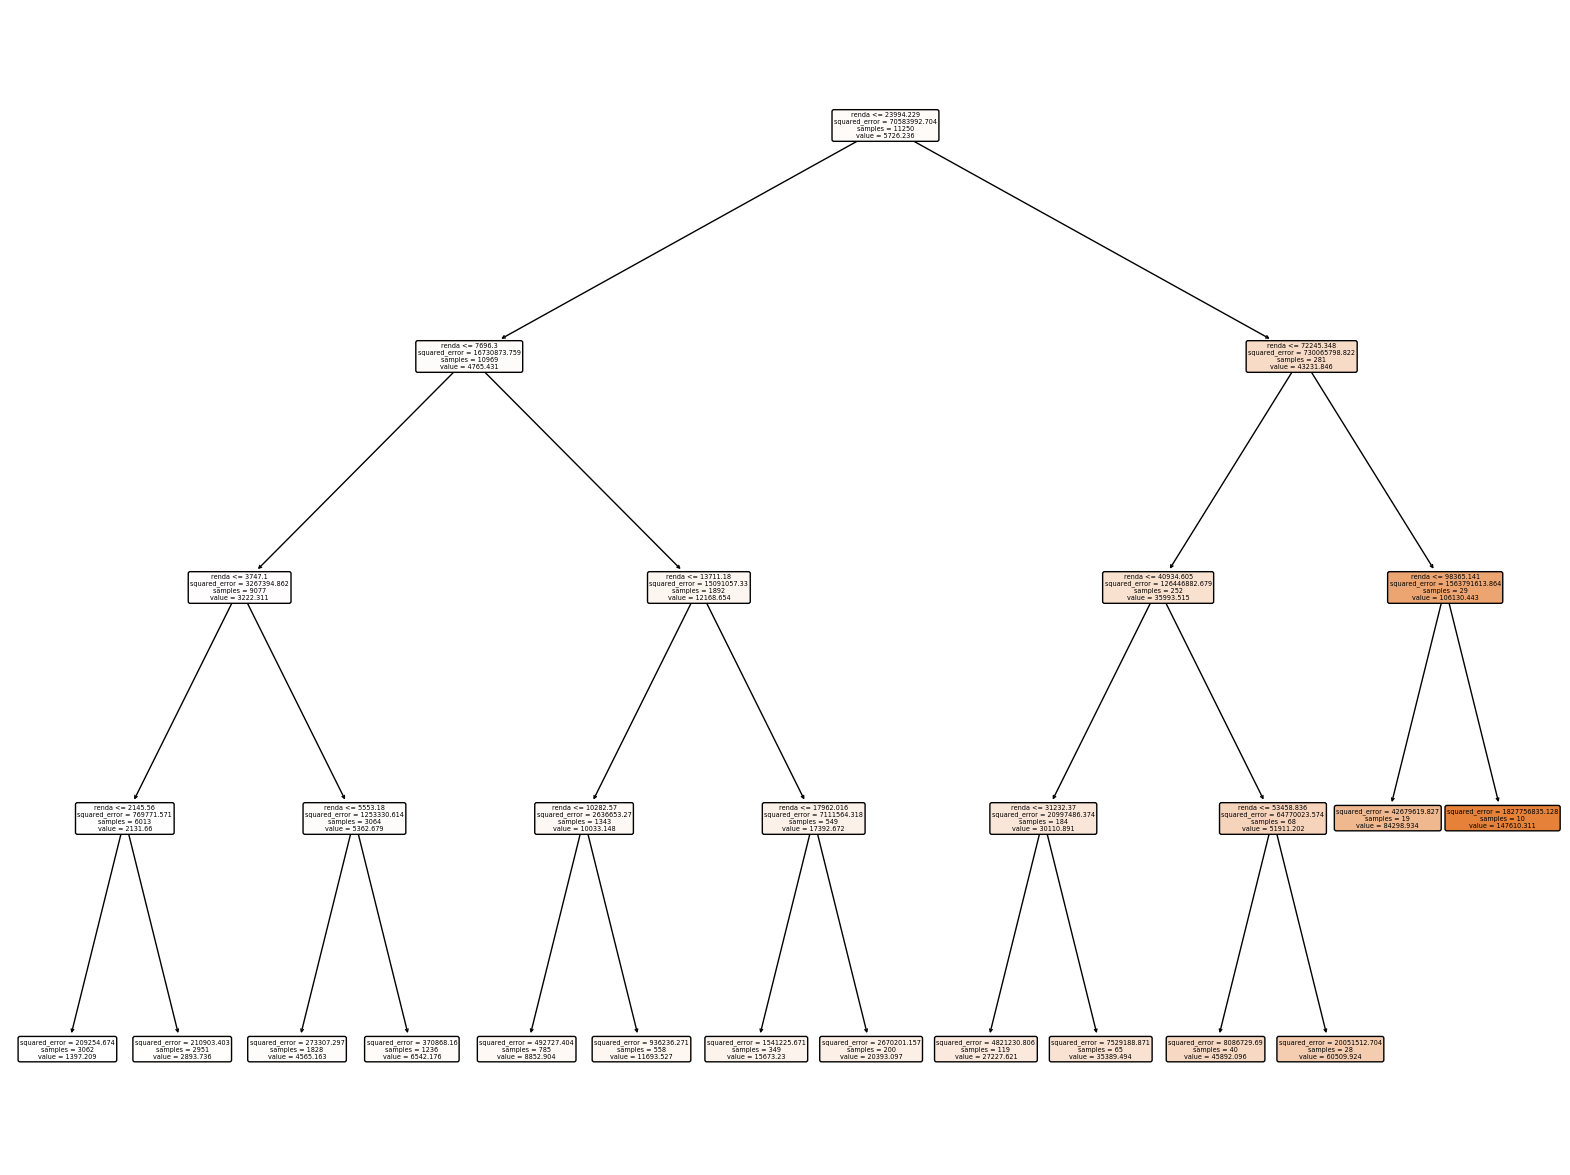

In [24]:
# Realizando a árvore de regressão com os hiperparâmetros escolhidos
regr_a = DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 10)
regr_a.fit(X_treino_dummies, y_treino_sw)

# Visualizando a árvore
plt.figure(figsize = (20, 15))
tree.plot_tree(regr_a, feature_names = X_treino_dummies.columns, filled=True, rounded=True)
plt.savefig("arvore_decisao.png")  # Salvando a imagem
plt.show()

In [25]:
# Calculando o R² da árvore usando o score()
r2_dt = regr_a.score(X_teste_dummies, y_teste)

print(f"Coeficiente de Determinação R² da Árvore de Regressão: {r2_dt: .3f}")

Coeficiente de Determinação R² da Árvore de Regressão:  0.986


**Conclusão por comparação nas bases teste:**

**RIDGE OPTIMIZADO:**
- R²: 0,362


**ÁRVORE DE REGRESSÃO:**
- R²: 0,986


A árvore de regressão apresentou resultado muito melhor do que o modelo que havia obtido melhor desempenho; sendo assim, a campeã desde estudo, frente a estes parâmetros avaliados na base teste.